In [2]:

# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pybaseball import statcast_batter
from pykalman import KalmanFilter

from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


In [3]:
# Choose a hitter and date range
# Kyle Schwarber
batter_id = 656941

start_date = "2024-04-01"
end_date   = "2024-09-30"


In [4]:
# Download Statcast batting data
print("Downloading Statcast data...")

data = statcast_batter(
    start_dt=start_date,
    end_dt=end_date,
    player_id=batter_id
)

print(f"Downloaded {len(data)} rows.")


Gathering Player Data
Downloaded 2822 rows.


In [5]:
# Aggregate to game-level statistics

data["game_date"] = pd.to_datetime(data["game_date"])

#walk events
data["bb"] = data["events"].isin(["walk", "hit_by_pitch","catcher_interf", "intent_walk"]).astype(int)

# hit_events
hit_events = ["single", "double", "triple", "home_run"]
data["hit"] = data["events"].isin(hit_events).astype(int)

# out_events
out_events=["strikeout", "field_out", "force_out","fielders_choice", "fielders_choice_out", "double_play", "triple_play", "grounded_into_double_play", "strikeout_double_play"]
data["is_out"] = data["events"].isin(out_events).astype(int)

data["at_bat"] = data["hit"] + data["is_out"]
data["plate_appearance"] = data["events"].notna().astype(int)

# Event types come from StatCast
# We compute classic metrics:
grouped = data.groupby("game_date").agg(
    pa=("plate_appearance", "sum"),
    ab=("at_bat", "sum"),
    hits=("hit", "sum"),
    hr=("events", lambda x: (x == "home_run").sum()),
    bb=("bb", "sum"),
)

# Compute metrics that can be derived from StatCast data:
grouped["obp"] = (grouped["hits"] + grouped["bb"]) / grouped["pa"]
grouped["hr_rate"] = grouped["hr"] / grouped["ab"].replace(0, np.nan)

# wOBA approximation (simplified weights)
grouped["woba"] = (
    0.69 * grouped["bb"] +
    0.89 * grouped["hits"] +        # 1B, simplification for starter notebook
    1.27 * grouped["hr"]            # substitute HR weight contribution
) / grouped["pa"]

grouped = grouped.dropna().sort_values("game_date")
grouped.head()


,pa,ab,hits,hr,bb,obp,hr_rate,woba
game_date,,,,,,,,
2024-04-01,4,4,2,0,0,0.5,0.000000,0.4450
2024-04-02,5,5,1,0,0,0.2,0.000000,0.1780
2024-04-03,4,3,1,1,1,0.5,0.333333,0.7125
2024-04-05,5,3,1,0,2,0.6,0.000000,0.4540
2024-04-06,5,5,0,0,0,0.0,0.000000,0.0000


In [7]:
# Extract observation vectors
observations = grouped[["obp", "woba", "hr_rate"]].values
dates = grouped.index

print(observations.shape)


(147, 3)


In [8]:
# Build a multivariate Kalman Filter

# State dimension = 3 (latent skill vector)
# Observation dimension = 3
kf = KalmanFilter(
    n_dim_state=3,
    n_dim_obs=3,
    
    transition_matrices=np.eye(3),       # Skill evolves as random walk
    observation_matrices=np.eye(3),

    transition_covariance=0.005 * np.eye(3),
    observation_covariance=0.02 * np.eye(3),

    initial_state_mean=observations[0]
)

filtered_state_means, _ = kf.filter(observations)

# Store results
for i, col in enumerate(["kf_obp", "kf_woba", "kf_hr"]):
    grouped[col] = filtered_state_means[:, i]

grouped.head()


,pa,ab,hits,hr,bb,obp,hr_rate,woba,kf_obp,kf_woba,kf_hr
game_date,,,,,,,,,,,
2024-04-01,4,4,2,0,0,0.5,0.000000,0.4450,0.500000,0.445000,0.000000
2024-04-02,5,5,1,0,0,0.2,0.000000,0.1780,0.334505,0.297710,0.000000
2024-04-03,4,3,1,1,1,0.5,0.333333,0.7125,0.408143,0.482272,0.148318
2024-04-05,5,3,1,0,2,0.6,0.000000,0.4540,0.486807,0.470680,0.087505
2024-04-06,5,5,0,0,0,0.0,0.000000,0.0000,0.293255,0.283540,0.052714


In [9]:
# Predict NEXT GAME performance using Kalman Filter
filtered_state_means, filtered_state_covs = kf.filter(observations)

# Predict next-time-step latent skill (no new observation)
next_state_mean, next_state_cov = kf.filter_update(
    filtered_state_means[-1],
    filtered_state_covs[-1],
    observation=None
)

print("Next-game predicted hitting skill:")
print(f"OBP  = {next_state_mean[0]:.3f}")
print(f"wOBA = {next_state_mean[1]:.3f}")
print(f"HR%  = {next_state_mean[2]:.3f}")



Next-game predicted hitting skill:
OBP  = 0.323
wOBA = 0.279
HR%  = 0.023


In [10]:

# Predict 7-game ahead forecast properly (rolling forward)


# Ensure we have filtered covariances stored

filtered_state_means, filtered_state_covs = kf.filter(observations)

# Start from the latest filtered mean and covariance

future_state = filtered_state_means[-1].copy()
future_cov   = filtered_state_covs[-1].copy()

# Propagate forward 7 steps with no new observations

for step in range(7):
    future_state, future_cov = kf.filter_update(
    future_state,
    future_cov,
    observation=None
    )

print("Predicted average performance for next 7-game horizon:")
print(f"OBP  = {future_state[0]:.3f}")
print(f"wOBA = {future_state[1]:.3f}")
print(f"HR%  = {future_state[2]:.3f}")

print("\nUncertainty (state variances):")
print(np.diag(future_cov))


Predicted average performance for next 7-game horizon:
OBP  = 0.323
wOBA = 0.279
HR%  = 0.023

Uncertainty (state variances):
[0.04280776 0.04280776 0.04280776]


In [11]:
# Compute a "slump probability" heuristic
# Slump = Predicted OBP below 20th percentile of season distribution
threshold = grouped["obp"].quantile(0.20)
slump_prob = (next_state_mean[0] < threshold)

print(f"Slump predicted next week? {slump_prob}")


Slump predicted next week? False


In [12]:
# Rolling ARIMA one-step-ahead predictions (aligned to grouped.index)
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import warnings

warnings.filterwarnings("ignore")

window = 7  # number of past games to use for forecasting
index = grouped.index

# Prepare an empty Series with the same index
arima_preds = pd.Series(index=index, dtype=float)

for i in range(len(grouped)):
    if i < window:
        arima_preds.iloc[i] = np.nan
        continue

    # training window: last `window` observed OBP values (exclude current index i)
    train_series = grouped["obp"].iloc[i - window : i]

    # If any NaNs or not enough valid points, skip
    if train_series.dropna().shape[0] < max(3, window // 2):
        arima_preds.iloc[i] = np.nan
        continue

    try:
        model = ARIMA(train_series, order=(1, 0, 0)).fit()
        pred = model.forecast(1).iloc[0]    # safe .iloc[0] to avoid KeyError
        arima_preds.iloc[i] = float(pred)
    except Exception as e:
        # on failure, put NaN and continue
        arima_preds.iloc[i] = np.nan

# Store into grouped (aligned by index)
grouped["arima_pred"] = arima_preds
print("ARIMA predictions computed — head of column:")
grouped["arima_pred"].head(12)


ARIMA predictions computed — head of column:


game_date
2024-04-01         NaN
2024-04-02         NaN
2024-04-03         NaN
2024-04-05         NaN
2024-04-06         NaN
2024-04-07         NaN
2024-04-08         NaN
2024-04-09    0.555022
2024-04-10    0.317620
2024-04-11    0.276359
2024-04-12    0.277704
2024-04-13    0.118582
Name: arima_pred, dtype: float64

In [13]:
# Train XGBoost baseline
# Features: lagged values
df = grouped.copy()
df["obp_lag1"] = df["obp"].shift(1)
df["obp_lag2"] = df["obp"].shift(2)
df["obp_lag3"] = df["obp"].shift(3)
df = df.dropna()

X = df[["obp_lag1", "obp_lag2", "obp_lag3"]]
y = df["obp"]

# Split train/test
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3
)

model.fit(X_train, y_train)
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"XGBoost RMSE = {rmse:.4f}")

# Next game prediction
last_row = df.iloc[-1]
x_pred = [[last_row.obp_lag1, last_row.obp_lag2, last_row.obp_lag3]]
xgb_pred = model.predict(x_pred)[0]

print(f"XGBoost next-game OBP prediction: {xgb_pred:.3f}")


XGBoost RMSE = 0.2912
XGBoost next-game OBP prediction: 0.398


In [14]:
# Rolling XGBoost Predictions Stored in `grouped`
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# Parameters
lags = [1, 2, 3]       # Number of previous games to use as features
min_window = 5         # Minimum number of training rows to allow prediction

# Create lag features
for lag in lags:
    grouped[f"obp_lag{lag}"] = grouped["obp"].shift(lag)

# Prepare series to hold predictions
xgb_preds = pd.Series(index=grouped.index, dtype=float)

# Walk-forward prediction
for i in range(max(lags), len(grouped)):

    # Current row's lag features
    current_row = grouped.iloc[i]
    X_pred_row = current_row[[f"obp_lag{l}" for l in lags]].values.reshape(1, -1)

    # Skip if any lag is NaN
    if np.isnan(X_pred_row).any():
        xgb_preds.iloc[i] = np.nan
        continue

    # Training data: all rows before i with valid lags
    train_df = grouped.iloc[:i].dropna(subset=["obp"] + [f"obp_lag{l}" for l in lags])

    if train_df.shape[0] < min_window:
        xgb_preds.iloc[i] = np.nan
        continue

    X_train = train_df[[f"obp_lag{l}" for l in lags]]
    y_train = train_df["obp"]

    # Fit model and predict
    try:
        model = XGBRegressor(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            objective="reg:squarederror",
            verbosity=0
        )
        model.fit(X_train, y_train)
        pred = float(model.predict(X_pred_row)[0])
        xgb_preds.iloc[i] = pred

        # Debug print to verify predictions are being made
        if i % 10 == 0:
            print(f"i={i}, predicted OBP={pred:.3f}, training rows={train_df.shape[0]}")

    except Exception as e:
        xgb_preds.iloc[i] = np.nan
        print(f"i={i}, Exception during XGBoost fit/predict: {e}")

# Store predictions in grouped
grouped["xgb_pred"] = xgb_preds

print("XGBoost predictions successfully added to grouped")
grouped[["obp", "xgb_pred"]].head(20)


i=10, predicted OBP=0.408, training rows=7
i=20, predicted OBP=0.393, training rows=17
i=30, predicted OBP=0.372, training rows=27
i=40, predicted OBP=0.393, training rows=37
i=50, predicted OBP=0.885, training rows=47
i=60, predicted OBP=0.191, training rows=57
i=70, predicted OBP=0.294, training rows=67
i=80, predicted OBP=0.339, training rows=77
i=90, predicted OBP=0.084, training rows=87
i=100, predicted OBP=0.354, training rows=97
i=110, predicted OBP=0.296, training rows=107
i=120, predicted OBP=0.250, training rows=117
i=130, predicted OBP=0.334, training rows=127
i=140, predicted OBP=0.366, training rows=137
XGBoost predictions successfully added to grouped


,obp,xgb_pred
game_date,,
2024-04-01,0.50,NaN
2024-04-02,0.20,NaN
2024-04-03,0.50,NaN
2024-04-05,0.60,NaN
2024-04-06,0.00,NaN
2024-04-07,0.50,NaN
2024-04-08,0.00,NaN
2024-04-09,0.25,NaN
2024-04-10,0.40,0.001599


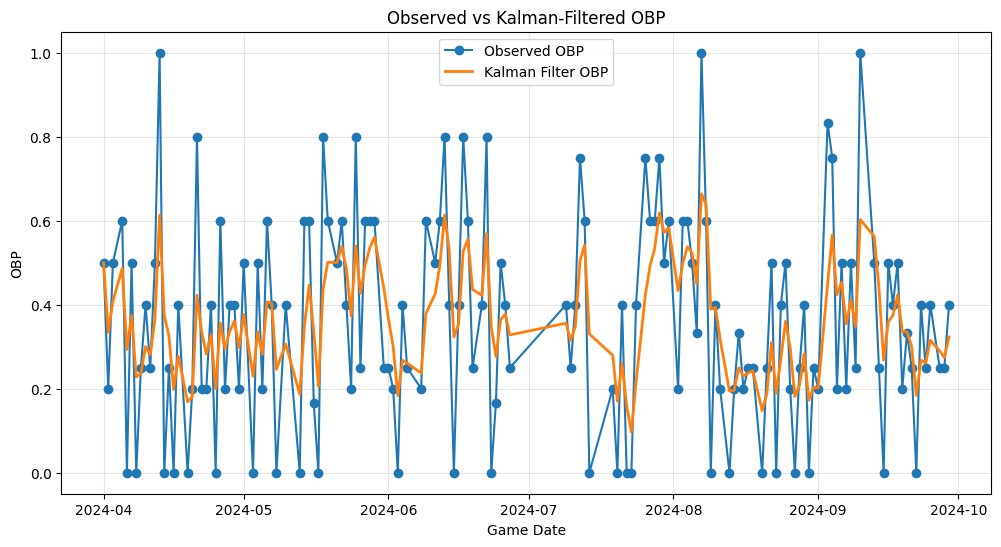

In [15]:
# Plot raw OBP vs filtered OBP
plt.figure(figsize=(12, 6))
plt.plot(dates, grouped["obp"], marker="o", label="Observed OBP")
plt.plot(dates, grouped["kf_obp"], linewidth=2, label="Kalman Filter OBP")

plt.title("Observed vs Kalman-Filtered OBP")
plt.xlabel("Game Date")
plt.ylabel("OBP")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


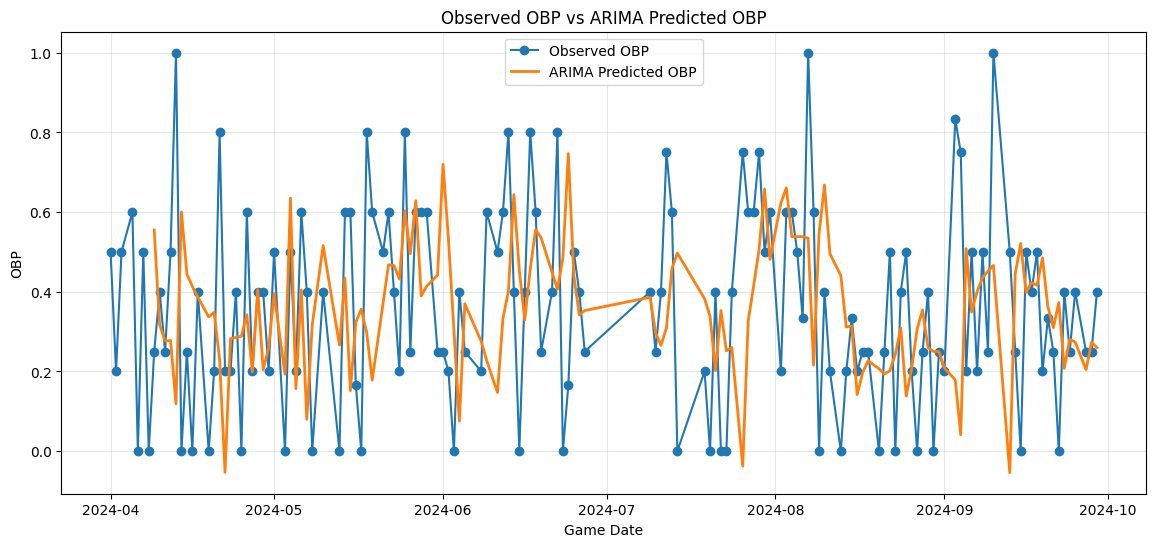

In [ ]:

# Plot Raw OBP vs ARIMA Prediction (using index as date)


import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(grouped.index,
grouped["obp"],
marker="o",
label="Observed OBP")

plt.plot(grouped.index,
grouped["arima_pred"],
linewidth=2,
label="ARIMA Predicted OBP")

plt.title("Observed OBP vs ARIMA Predicted OBP")
plt.xlabel("Game Date")
plt.ylabel("OBP")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


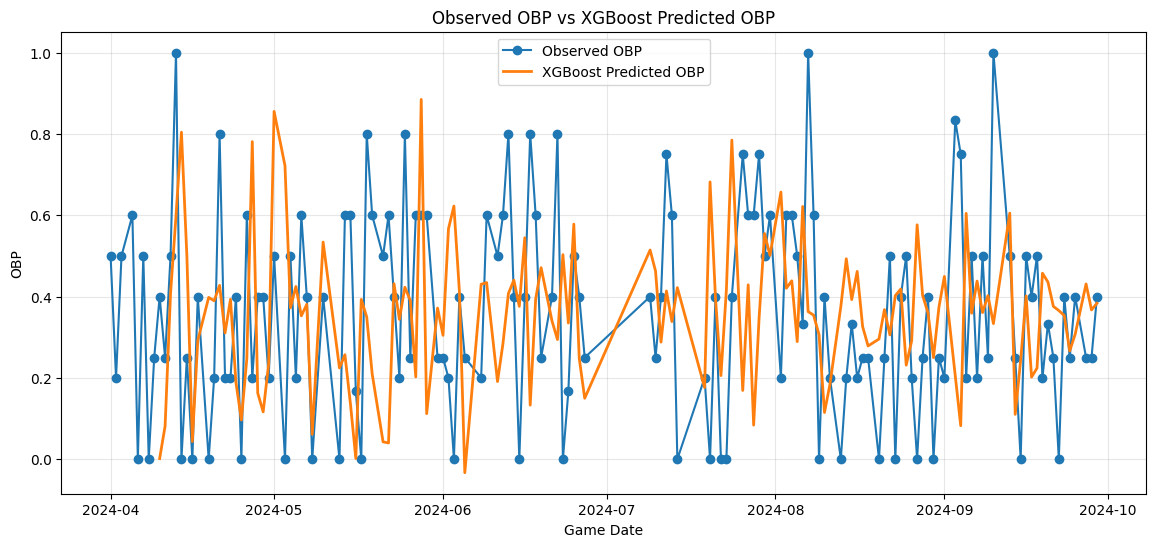

In [ ]:

# Plot Raw OBP vs XGBoost Prediction (using index)


import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(grouped.index,
grouped["obp"],
marker="o",
label="Observed OBP")

plt.plot(grouped.index,
grouped["xgb_pred"],
linewidth=2,
label="XGBoost Predicted OBP")

plt.title("Observed OBP vs XGBoost Predicted OBP")
plt.xlabel("Game Date")
plt.ylabel("OBP")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
